### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import csv
from graphviz import Digraph
from sklearn.metrics import f1_score
import csv
from sklearn.metrics import accuracy_score

### KNN

In [ ]:
iris_orig_data = pd.read_csv('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/ml_hw_1/Iris.csv')
iris_orig_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
scaler = MinMaxScaler()
iris_scaled_data = iris_orig_data.copy()
cols_to_scale = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
iris_scaled_data[cols_to_scale] = scaler.fit_transform(iris_scaled_data[cols_to_scale])

In [ ]:
le = LabelEncoder()
iris_scaled_data['Species'] = le.fit_transform(iris_scaled_data['Species'])

In [ ]:
X = iris_scaled_data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y = iris_scaled_data['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def add_noise(X_train, y_train, noise_type, noise_level):
    X_train_noisy = X_train.copy()
    y_train_noisy = y_train.copy()

    if noise_type == 'feature':
        noise = np.random.rand(*X_train.shape) * noise_level / 100
        X_train_noisy = X_train_noisy + noise

    elif noise_type == 'label':
        num_samples_to_change = int(len(y_train) * noise_level / 100)
        random_indices = np.random.choice(len(y_train), num_samples_to_change, replace=False)
        unique_labels = y_train.unique()
        for index in random_indices:
            new_label = np.random.choice(unique_labels[unique_labels != y_train.iloc[index]])
            y_train_noisy.iloc[index] = new_label

    return X_train_noisy, y_train_noisy

X_train_noisy20_feature, y_train_noisy20_feature = add_noise(X_train, y_train, 'feature', 20)
X_train_noisy20_label, y_train_noisy20_label = add_noise(X_train, y_train, 'label', 20)

X_train_noisy40_feature, y_train_noisy40_feature = add_noise(X_train, y_train, 'feature', 40)
X_train_noisy40_label, y_train_noisy40_label = add_noise(X_train, y_train, 'label', 40)

In [ ]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

In [ ]:
def five_fold_cross_validation(X, y, k_neighbors=3):
    num_folds = 5
    fold_size = len(X) // num_folds
    accuracy_scores = []

    for fold in range(num_folds):
        X_train = np.concatenate([X[:fold * fold_size], X[(fold + 1) * fold_size:]])
        y_train = np.concatenate([y[:fold * fold_size], y[(fold + 1) * fold_size:]])
        X_val = X[fold * fold_size:(fold + 1) * fold_size]
        y_val = y[fold * fold_size:(fold + 1) * fold_size]

        knn = KNN(k=k_neighbors)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_val)

        accuracy = np.sum(y_pred == y_val) / len(y_val)
        accuracy_scores.append(accuracy)

    return accuracy_scores

k_values = [1, 5, 9]
noise_levels = ['original', 'noisy20', 'noisy40']
results = []

for k in k_values:
    for noise_level in noise_levels:
        if noise_level == 'original':
            X_train_data = X_train.to_numpy()
            y_train_data = y_train.to_numpy()
        elif noise_level == 'noisy20':
            X_train_data = X_train_noisy20_feature.to_numpy()
            y_train_data = y_train_noisy20_label.to_numpy()
        elif noise_level == 'noisy40':
            X_train_data = X_train_noisy40_feature.to_numpy()
            y_train_data = y_train_noisy40_label.to_numpy()

        accuracy_scores = five_fold_cross_validation(X_train_data, y_train_data, k_neighbors=k)

        mean_accuracy = np.mean(accuracy_scores)
        results.append([k, noise_level, mean_accuracy])

In [ ]:
results

[[1, 'original', 0.9416666666666667],
 [1, 'noisy20', 0.65],
 [1, 'noisy40', 0.41666666666666663],
 [5, 'original', 0.9416666666666668],
 [5, 'noisy20', 0.7],
 [5, 'noisy40', 0.45],
 [9, 'original', 0.95],
 [9, 'noisy20', 0.7416666666666667],
 [9, 'noisy40', 0.5333333333333333]]

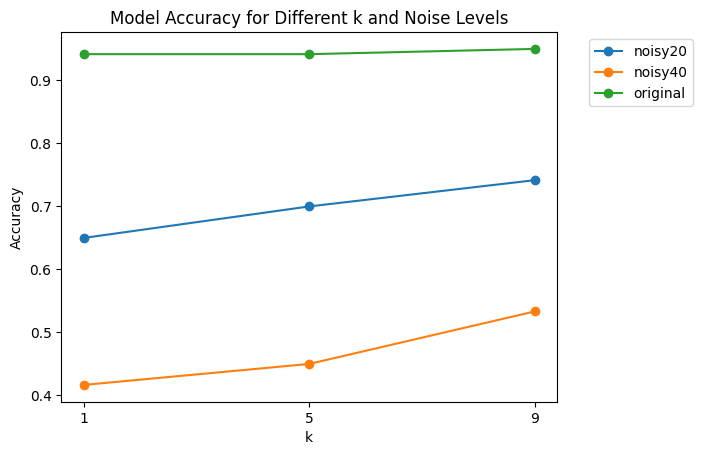

In [ ]:
accuracy_data = results.copy()

k_values = np.unique([data[0] for data in accuracy_data])
noise_levels = [data[1] for data in accuracy_data]
accuracies = [data[2] for data in accuracy_data]

unique_noise_levels = np.unique(noise_levels)
for noise_level in unique_noise_levels:
    filtered_data = [data for data in accuracy_data if data[1] == noise_level]
    accuracies_filtered = [data[2] for data in filtered_data]
    plt.plot(k_values, accuracies_filtered, marker='o', label=noise_level)

plt.title('Model Accuracy for Different k and Noise Levels')
plt.xlabel('k')
plt.xticks(k_values)
plt.ylabel('Accuracy')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

### Prism

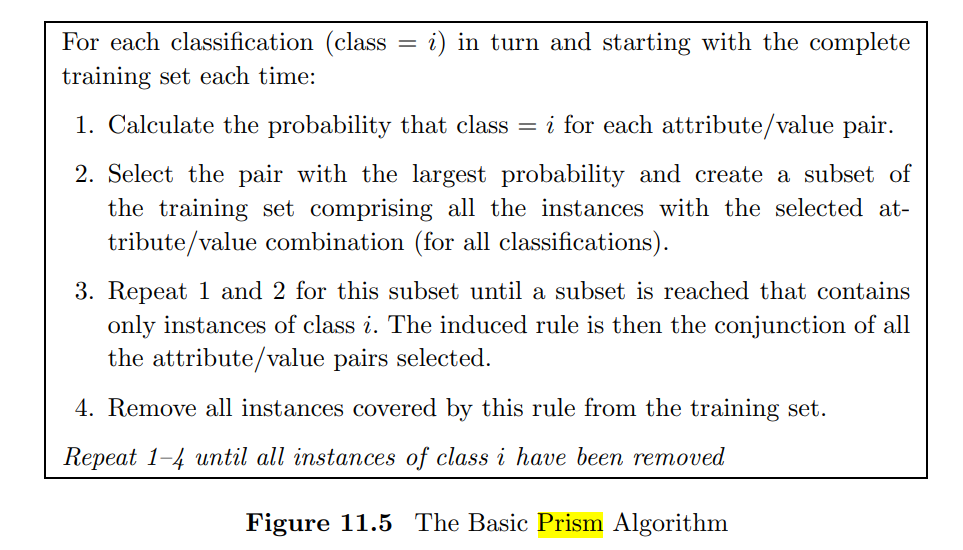

In [ ]:
mushroom_orig_data = pd.read_csv('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/ml_hw_1/mushrooms.csv')
mushroom_orig_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


#### Preprocessing

In [ ]:
data = mushroom_orig_data.copy()
data = data.dropna()

X = data.drop(columns='class')
y = data['class']

#### Algorithm

In [ ]:
class PrismClassifier:
    def __init__(self, min_support=0.1):
        self.min_support = min_support
        self.final_rules = []

    def fit(self, X, y):
        X_copy = X.reset_index(drop=True)
        y_copy = y.reset_index(drop=True)

        for class_label in y_copy.unique():
            perfect_rule_found = False
            while not perfect_rule_found:
                best_rule = None
                best_accuracy = 0

                for feature in X_copy.columns:
                    for value in X_copy[feature].unique():
                        rule = (feature, value)
                        covered_indices = X_copy[X_copy[feature] == value].index
                        support = len(covered_indices) / len(X_copy)

                        covered_y = y_copy[X_copy.index.isin(covered_indices)]

                        acc = covered_y.value_counts(normalize=True).get(class_label, 0)

                        if support >= self.min_support and acc > best_accuracy:
                            best_accuracy = acc
                            best_rule = rule

                if best_rule:
                    self.final_rules.append((best_rule, class_label))
                    X_copy = X_copy[X_copy[best_rule[0]] != best_rule[1]]
                    y_copy = y_copy[X_copy.index]
                    X_copy = X_copy.reset_index(drop=True)
                    y_copy = y_copy.reset_index(drop=True)

                    if len(X_copy) == 0:
                        perfect_rule_found = True
                else:
                    perfect_rule_found = True

    def predict(self, X):
        pred = []
        for _, instance in X.iterrows():
            predicted_class = self._classify_instance(instance)
            pred.append(predicted_class)
        return np.array(pred)

    def _classify_instance(self, instance):
        for rule, class_label in self.final_rules:
            if isinstance(instance[rule[0]], str):
                if instance[rule[0]] == rule[1]:
                    return class_label
            else:
                if instance[rule[0]] == rule[1]:
                    return class_label

        return 'unknown'

    def rules(self):
        class_1_rules = []
        class_0_rules = []
        for rule, class_label in self.final_rules:
            conditions = []
            for f in rule:
                if f != rule[1]:
                    conditions.append(f"{f}={rule[1]}")
            rule_string = " AND ".join(conditions)

            if class_label == 'p':
                class_1_rules.append(rule_string)
            else:
                class_0_rules.append(rule_string)
        print("IF", " AND " .join(class_1_rules) + " THEN class=p")

        print("IF", " AND " .join(class_0_rules) + " THEN class=e")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = PrismClassifier(min_support=0.001)
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)


Prism = PrismClassifier()
Prism.fit(X_train, y_train)
Prism.rules()
accuracy = accuracy_score(y_test, predictions)
print(accuracy)


IF odor=f AND gill-color=b AND gill-size=n AND ring-number=t AND stalk-root=c THEN class=p
IF cap-shape=f AND cap-shape=x AND cap-shape=k AND cap-shape=b THEN class=e
0.9661538461538461


### ID3

#### Preprocessing

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/ml_hw_1/titanic.csv')
data=  data.drop(data.columns[0], axis=1)
data["age"] = data["age"].fillna(data["age"].mean())
data["embarked"] = data["embarked"].fillna(data["embarked"].mode()[0])


data['fare_bin'] = pd.qcut(data['fare'], 4, labels=False)
data = data.drop('fare', axis=1)
label_encoder = LabelEncoder()
data["sex"] = label_encoder.fit_transform(data["sex"])
data["embarked"] = label_encoder.fit_transform(data["embarked"])

X = data.drop("survived", axis=1)
y = data["survived"]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

#### Algorithm

In [2]:
class ID3DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion="information_gain"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for _, sample in X.iterrows()])

    def _build_tree(self, X, y, depth):
        if len(y) == 0:
            return None
        if depth == self.max_depth or len(set(y)) == 1 or len(X) < self.min_samples_split:
            return np.bincount(y).argmax()

        best_feature, best_threshold = self._find_best_split(X, y)

        if best_feature is None:
            return np.bincount(y).argmax()

        left_index = X[best_feature] < best_threshold
        right_index = X[best_feature] >= best_threshold

        left_subtree = self._build_tree(X[left_index], y[left_index], depth + 1)
        right_subtree = self._build_tree(X[right_index], y[right_index], depth + 1)

        return {best_feature: {best_threshold: left_subtree, "else": right_subtree}}

    def _find_best_split(self, X, y):
        best_gain = -float("inf")
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                gain = self._calculate_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, X, y, feature, threshold):
        if self.criterion == "information_gain":
            return self._information_gain(X, y, feature, threshold)
        elif self.criterion == "information_gain_ratio":
            return self._information_gain_ratio(X, y, feature, threshold)
        elif self.criterion == "gini_index":
            return self._gini_index(X, y, feature, threshold)

    def _information_gain(self, X, y, feature, threshold):
        total_entropy = self._entropy(y)
        left_index = X[feature] < threshold
        right_index = X[feature] >= threshold

        left_entropy = self._entropy(y[left_index])
        right_entropy = self._entropy(y[right_index])

        weighted_left_entropy = len(y[left_index]) / len(y) * left_entropy
        weighted_right_entropy = len(y[right_index]) / len(y) * right_entropy

        return total_entropy - (weighted_left_entropy + weighted_right_entropy)

    def _information_gain_ratio(self, X, y, feature, threshold):
        information_gain = self._information_gain(X, y, feature, threshold)
        intrinsic_value = self._entropy(y)

        if intrinsic_value == 0:
            return 0
        else:
            return information_gain / intrinsic_value

    def _gini_index(self, X, y, feature, threshold):
        total_gini = self._gini(y)
        left_index = X[feature] < threshold
        right_index = X[feature] >= threshold

        left_gini = self._gini(y[left_index])
        right_gini = self._gini(y[right_index])

        weighted_left_gini = len(y[left_index]) / len(y) * left_gini
        weighted_right_gini = len(y[right_index]) / len(y) * right_gini

        return total_gini - (weighted_left_gini + weighted_right_gini)

    def _entropy(self, y):
        value_counts = np.bincount(y)
        probabilities = value_counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))

    def _gini(self, y):
        value_counts = np.bincount(y)
        probabilities = value_counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            feature = next(iter(tree))
            thresholds = tree[feature]
            threshold = next(iter(thresholds))

            if sample[feature] is None:
                return 0

            if sample[feature] < threshold:
                return self._predict_sample(sample, thresholds[threshold])
            else:
                return self._predict_sample(sample, thresholds["else"])
        else:
            return tree


In [5]:
best_params = {}
best_f1 = 0
results = []

for max_depth in [3, 5, 9, 11]:
    for min_samples_split in [2, 10, 30, 40]:
        for criterion in ["information_gain", "information_gain_ratio", "gini_index"]:
            tree = ID3DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
            tree.fit(X_train, y_train)
            y_pred_val = tree.predict(X_val)
            f1 = f1_score(y_val, y_pred_val)
            results.append([criterion, max_depth, min_samples_split, f1])

            if f1 > best_f1:
                best_params = {"max_depth": max_depth, "min_samples_split": min_samples_split, "criterion": criterion}
                best_f1 = f1

with open("results.csv", "w", newline="") as csvfile:
    fieldnames = ["criterion", "max_depth", "min_samples_split", "f1_score"]
    writer = csv.writer(csvfile)
    writer.writerow(fieldnames)
    writer.writerows(results)

print("Best parameters:", best_params)

Best parameters: {'max_depth': 9, 'min_samples_split': 10, 'criterion': 'gini_index'}


In [10]:
tree = ID3DecisionTree(**best_params)

best_test_f1 = 0
best_test_accuracy = 0
for max_depth in [3, 5, 9, 11]:
    for min_samples_split in [2, 10, 30, 40]:
        for criterion in ["information_gain", "information_gain_ratio", "gini_index"]:
            tree = ID3DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
            tree.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
            y_pred = tree.predict(X_test)
            y_pred = np.nan_to_num(y_pred)
            y_pred = y_pred.astype(float)
            y_pred = np.nan_to_num(y_pred, nan=0)
            f1 = f1_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            if f1 > best_test_f1:
                best_test_f1 = f1
            if accuracy > best_test_accuracy:
                best_test_accuracy = accuracy
            print("max_depth: ", max_depth, "min_samples_split: ", min_samples_split, "f1_score: ", f1, "accuracy: ", accuracy)

max_depth:  3 min_samples_split:  2 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  2 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  2 f1_score:  0.6896551724137931 accuracy:  0.7482517482517482
max_depth:  3 min_samples_split:  10 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  10 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  10 f1_score:  0.6896551724137931 accuracy:  0.7482517482517482
max_depth:  3 min_samples_split:  30 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  30 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  30 f1_score:  0.6896551724137931 accuracy:  0.7482517482517482
max_depth:  3 min_samples_split:  40 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 min_samples_split:  40 f1_score:  0.640625 accuracy:  0.6783216783216783
max_depth:  3 mi

In [11]:
print(best_test_accuracy)
print(best_test_f1)

0.8181818181818182
0.74
